In [217]:
import accelerate
import datasets
import evaluate
import numpy as np
import peft
import pickle
import pytest, ipytest
ipytest.autoconfig()
import pandas as pd
import transformers

from datasets import(
    load_dataset, 
    load_dataset_builder,
    get_dataset_split_names,
    get_dataset_config_names,
)


from peft import(
    LoftQConfig,
    LoraConfig,
    get_peft_model,
)

from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from trl import SFTTrainer, SFTConfig
# allows fast processing of datasets

In [3]:
ds_builder1=load_dataset_builder("LongSafari/open-genome", "stage1")
print(ds_builder1.info.features)
ds_builder2=load_dataset_builder("LongSafari/open-genome", "stage2")
print(ds_builder2.info.features)
ds_builder3=load_dataset_builder("LongSafari/open-genome", "sample")
print(ds_builder3.info.features)

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}


In [4]:
ds_gs=load_dataset("LongSafari/open-genome", "sample")
get_dataset_split_names("LongSafari/open-genome", "sample")

['validation']

In [5]:
ds_gst1_train=load_dataset("LongSafari/open-genome", "stage1", split="train[:500]")
#print(ds_gst1[50])
ds_gst1_test=load_dataset("LongSafari/open-genome", "stage1", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage1"))
ds_gst2_train=load_dataset("LongSafari/open-genome", "stage2", split="train[:500]")
ds_gst2_test=load_dataset("LongSafari/open-genome", "stage2", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage2"))

['train', 'validation', 'test']
['train', 'validation', 'test']


In [16]:
print(ds_gst1_test[0])

{'record': 'JAHFAU010000168.1', 'text': 'CTCCTCGGCCAGCAAGCGCATCGTGAGAACCGGACTGACGATCAGCAAAACGGTCGCCAGCGGGCCCAATACCATGCGGCCATCCGGGTTCATCTGGCCGGTCGGCAGGCCAAAGTTAACGTTTAGGGAGAAGATCAGGCCGAGCACCAGGAAGCTGAGGGCGGCGGCCGCGTAAGCCAGCGGCGACACGAAGTAGCGGCGGAACTCGCGCACTGCAATAACCCAGCTGGTGCGCACGATCTAGCTCTCCTGCGGCACGACTTGCTCTTCCTCGCGAGTCAGCAGCAGGAAGATGCTTTCCAGGCTGACCCCGGCCGTTGTCAGCTCCAGCAAGTCCAGATCGGCTTCAACGATGCGGCGCGCCAACAGCGGGCGCAGGTCGCGGCCGGGCGAAGAGATCACCTCCACGGTGCCTGCCTGCCCGGCAAGCTCGACCGACTCCACTCCCGGGACGGACTTGAGCAGGTCGACCAGATCGGCTGCCGGGGCAGAGCTGCGGATCAGAATCCGGTACGCACCGGCCAGCTGGGCCGAAAGATTGGCGGGCGTATCTTCCGCCACCAACCGCCCCTTGTTGATAATCAGGACTCGATCACAAACTTGCTGTGCTTCCGAGAGGATGTGGGTGGACAACATGACGGTCCGCTCCCGCCCGAGCTCTCGGATTAAGTCCCGGACTTCGATGATTTGGGCCGGATCCAGTCCAATGGTCGGCTCGTCCAGGATCAAGACCTCGGGCCGGTGCAAGAGTGCCTGGGCCAGGCCGACCCGCTGTCGCAGACCTTTCGACAGGTTGCCAATCAGGCTATCACCGCGTTTTTCGAGGCCGACCTGCGTTAGGGATTCCTCGACCCGGCCATCCAGGTCCTCCACCCGCCGAAGCGAACCCATGAACGAGAGGTATTCGCGGCCGGACATCTCCGGGTACAGCGGGACGGTCTCCGGCAGGTATCCGACCC

In [6]:
def model_from_pkl(model):
    with open("pkl_files/" + model + ".pkl", "rb") as f:
        pkl_model=pickle.load(f)
    model_name=pkl_model["model_name"]
    tokenizer=pkl_model["tokenizer"]
    tokenizer.pad_token=tokenizer.eos_token
    return model_name, tokenizer

In [7]:
%%ipytest -k imp
#test to check models are properly improted from pkl files
def test_model_imp():
    lla_321, lla_321_tokenizer=model_from_pkl("Llama-3.2-1B")
    assert type(lla_321)==transformers.models.llama.modeling_llama.LlamaForCausalLM and type(lla_321_tokenizer)==transformers.tokenization_utils_fast.PreTrainedTokenizerFast
          

.                                                                                            [100%]
1 passed in 3.46s


In [8]:
lla_321, lla_321_tokenizer=model_from_pkl("Llama-3.2-1B")

In [10]:
lla_323, lla_323_tokenizer=model_from_pkl("Llama-3.2-3B")

In [9]:
mistral, mistral_tokenizer=model_from_pkl("Mistral-7B-Instruct-v0.1")

In [127]:
# perform preprocessing on the genomic data
def map_data(data, model, tokenizer):
    def tokenize_l_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)
    def tokenize_m_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=1024)
        
    if type(model)==transformers.models.llama.modeling_llama.LlamaForCausalLM:
        tokenized_dataset=data.map(tokenize_l_function, batched=True)
    else:
        tokenized_dataset=data.map(tokenize_m_function, batched=True)
    return tokenized_dataset

In [128]:
l_tokenized_genome_samples=map_data(ds_gs, lla_321, lla_321_tokenizer)
m_tokenized_genome_samples=map_data(ds_gs, mistral, mistral_tokenizer)

Map: 100%|██████████████████| 50/50 [00:00<00:00, 224.28 examples/s]


In [129]:
l_tokenized_stage1_train=map_data(ds_gst1_train, lla_321, lla_321_tokenizer)
l_tokenized_stage1_test=map_data(ds_gst1_test, lla_321, lla_321_tokenizer)

In [14]:
l_tokenized_stage2_train=map_data(ds_gst2_train, lla_321, lla_321_tokenizer)
l_tokenized_stage2_test=map_data(ds_gst2_test, lla_321, lla_321_tokenizer)

In [130]:
m_tokenized_stage1_train=map_data(ds_gst1_train, mistral, mistral_tokenizer)
m_tokenized_stage1_test=map_data(ds_gst1_test, mistral, mistral_tokenizer)

Map: 100%|██████████████████| 50/50 [00:00<00:00, 669.82 examples/s]


In [16]:
m_tokenized_stage2_train=map_data(ds_gst2_train, mistral, mistral_tokenizer)
m_tokenized_stage2_test=map_data(ds_gst2_test, mistral, mistral_tokenizer)

In [17]:
# before loading in the base model with LoRA, might be good to define a helper function
# this looks at the total parameters a model has, and how many are trainable
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [32]:
training_args=TrainingArguments(output_dir="test_trainer", 
                                eval_strategy="epoch", 
                                per_device_train_batch_size=8,
                                num_train_epochs=3, # total number of training epochs to perform)
                                learning_rate=2e-4,
                                weight_decay=0.1,
                                logging_strategy="steps",
                                logging_steps=2)
# eval_strategy=epoch ensures that the evaluation metric will be reported at the end of each epoch
# this helps us monitor evaluation metrics during fine-tuning

# an epoch is one full cycle through a training dataset
# during the epoch, the model sees and learns from all the training examples
# steps are one optimization update
# during a step, parameters are updated based on a batch of training data
#the number of steps per epoch is the total number of training samples divided by batch size
# here we have 3 epochs, 48 steps, 16 steps per epoch
# epochs are best used when you want the model to see the dataset several times, 
 #steps are best used for larger datasets to ensure updates

In [19]:
# A trainer needs to be passed a function from the Evaluate library (specifically the accuracy function) to compute and report metrics
metric=evaluate.load("accuracy")

In [131]:
# the compute_metrics method will calculate prediction accuracy
comp_metrics_output=[]
def compute_metrics(eval_pred):
    logits=eval_pred.predictions
    refs=eval_pred.label_ids
    log_32=logits.astype(np.int32)
    log_32=np.concatenate(log_32).tolist()
    ref_32=refs.astype(np.int32)
    ref_32=np.concatenate(ref_32).tolist()
    predictions = np.argmax(log_32, axis=-1)
    met=metric.compute(predictions=predictions, references=ref_32)
    comp_metrics_output.append(met)
    return met
    # this lets us convert logits (returned by models) into predictions
    # np.argmax returns the indices of the maximum values along the axis of an array
    # axis=-1 means it looks at the last axis in the array
    # metric.compute gathers all cached predictions and references to compute the metric scor

In [132]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [133]:
# the trainer object specifies the model, training arguments, training and test datasets, and evaluation function
def make_trainer(m_model, train_data, test_data, args):
    trainer=SFTTrainer(
        model=m_model,
        train_dataset=train_data,
        eval_dataset=test_data,
        peft_config=config,
        args=args,
        compute_metrics=compute_metrics,
        )
    return trainer
    
# SFTTrainer is best used for training with a pre-trained model and a smaller dataset
# It can be better suited for fine-tuning than regular Trainer


In [134]:
mis_lora_model=get_peft_model(mistral, config)
print_trainable_parameters(mis_lora_model)

trainable params: 3407872 || all params: 7245139968 || trainable%: 0.05


In [135]:
m_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps", 
                                    logging_steps=6, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

# Using the SFTConfig default values provides us with...
# num_train_epochs = 3.0
# eval_strategy: typing.Union[transformers.trainer_utils.IntervalStrategy, str] = 'no'
# per_device_train_batch_size = 8
# learning_rate = 2e-5
# gradient_checkpointing=False

Truncating train dataset: 100%|█| 500/500 [00:00<00:00, 2677.62 exam
Truncating eval dataset: 100%|█| 50/50 [00:00<00:00, 5833.04 example


In [136]:
m_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
6,0.652600,2.571135,0.027148
12,0.644100,2.527507,0.026348
18,0.631700,2.499065,0.027734
24,0.630200,2.482689,0.028398
30,0.626700,2.473098,0.028086
36,0.624000,2.467157,0.027891
42,0.620800,2.463838,0.027969
48,0.623100,2.462873,0.028438


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch

TrainOutput(global_step=48, training_loss=0.6316352883974711, metrics={'train_runtime': 1594.9454, 'train_samples_per_second': 0.94, 'train_steps_per_second': 0.03, 'total_flos': 6.5563250393088e+16, 'train_loss': 0.6316352883974711})

,loss,eval_loss,eval_accuracy
step,,,
6,0.6526,2.571135,0.027148
12,0.6441,2.527507,0.026348
18,0.6317,2.499065,0.027734
24,0.6302,2.482689,0.028398
30,0.6267,2.473098,0.028086
36,0.6240,2.467157,0.027891
42,0.6208,2.463838,0.027969
48,0.6231,2.462873,0.028438


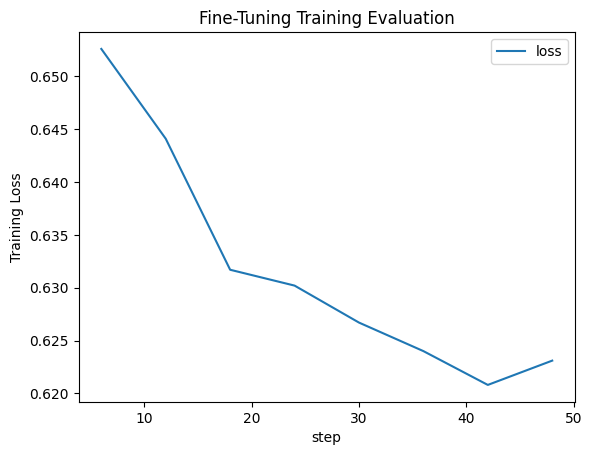

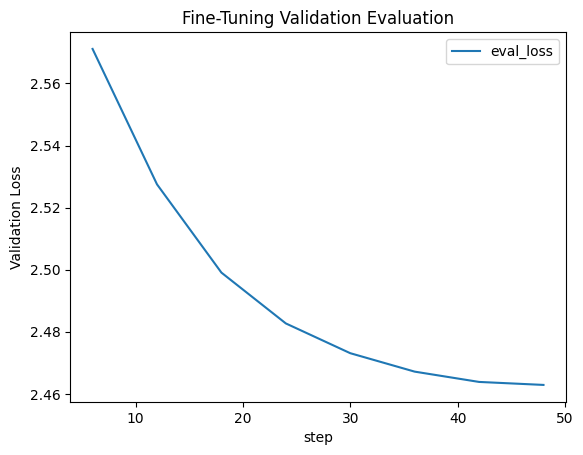

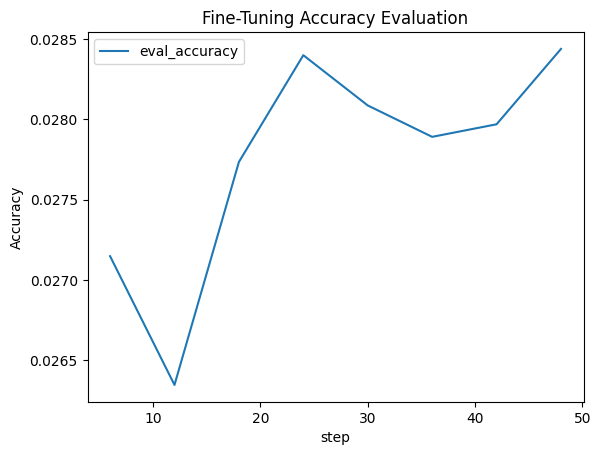

In [149]:
output=get_training_output(m_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [ ]:
m2_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps", 
                                    logging_steps=2, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

In [144]:
m2_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.614500,2.441753,0.002305
2,0.612300,2.434106,0.006953
3,0.616900,2.431262,0.008164


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=48, training_loss=0.6159106865525246, metrics={'train_runtime': 1095.4936, 'train_samples_per_second': 1.369, 'train_steps_per_second': 0.044, 'total_flos': 6.5563250393088e+16, 'train_loss': 0.6159106865525246})

,loss,eval_loss,eval_accuracy
epoch,,,
1.0,0.6145,2.441753,0.002305
2.0,0.6123,2.434106,0.006953
3.0,0.6169,2.431262,0.008164


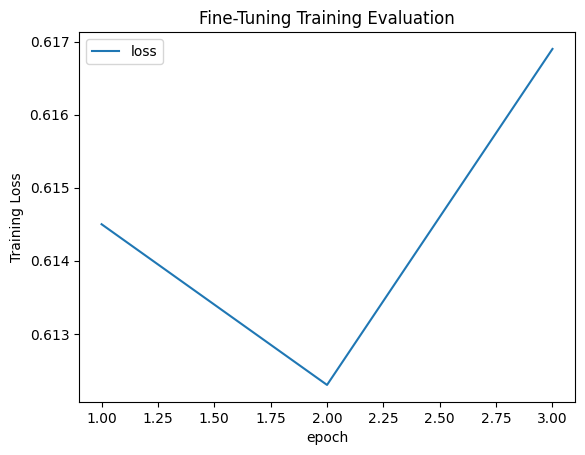

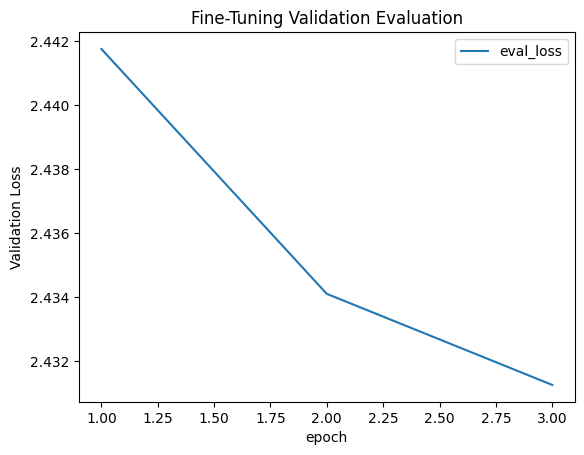

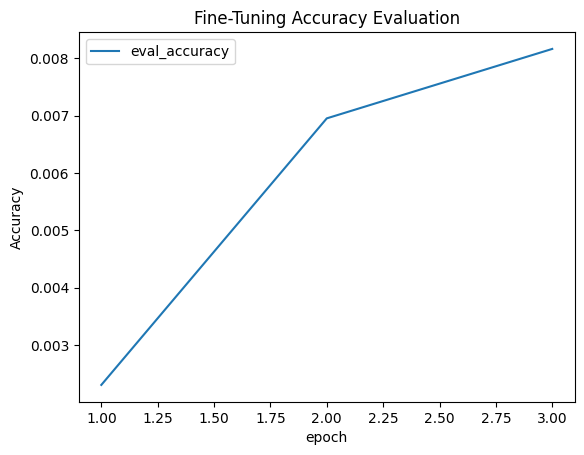

In [148]:
output=get_training_output(m2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [36]:
lla_lora_model=get_peft_model(lla_321, config)
print_trainable_parameters(lla_lora_model)

trainable params: 851968 || all params: 1236666368 || trainable%: 0.07


In [66]:
l_trainer=make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps",
                                    logging_steps=2))

In [67]:
l_trainer.train() #same arguments as m_trainer

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.642500,2.572258,0.000215
2,0.644500,2.569842,0.000273
3,0.648900,2.568797,0.000352


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=48, training_loss=0.6465414439638456, metrics={'train_runtime': 1121.7611, 'train_samples_per_second': 1.337, 'train_steps_per_second': 0.043, 'total_flos': 8976366305280000.0, 'train_loss': 0.6465414439638456})

## Training Loss
* Measures how well the models are performing on the training data, used to update parameters, decreases as model learns
* Too low means model may have overfit
## Validation Loss
* Measures how well the model is performing on the separate validation set (the test set in this case)
* Shows how well model generalizes to data it hasn't seen, if this increases while training loss decreases, there is overfitting
## Accuracy
* How often a correct outcome is predicted

In [203]:
def get_dataframe(training_output: list, strategy):
    df=pd.DataFrame(training_output) # convert the imported list of dictionaries to a DataFrame
    #df=training_output
    df.index=df[strategy] # the index of the dataframe is whatever evaluation strategy was used
    df=df.drop([strategy], axis=1) # drop one column so there aren't two step/epoch columns
    df.plot(y=0, xlabel=strategy, ylabel="Training Loss", title="Fine-Tuning Training Evaluation") # plot training loss
    df.plot(y=1, xlabel=strategy, ylabel="Validation Loss", title="Fine-Tuning Validation Evaluation") # plot validation loss
    df.plot(y=2, xlabel=strategy, ylabel="Accuracy", title="Fine-Tuning Accuracy Evaluation") # plot accuracy
    #for all of the above plots, the evaluation strategy (the index) is the x-axis value
    return df

In [202]:
def get_training_output(trainer, keys: list):
    trainer_info=[]
    temp_dict={}
    logs=trainer.state.log_history # get the logs from model training, these show training loss, accuracy, etc
    strat=trainer.args.eval_strategy.value # was this evaluated at steps or epochs

    def check_eval():
        if (strat=='epoch'):
            #strat='epoch'
            condition= i['epoch'].is_integer() 
            # if evaluated at epochs, extract data at the points where epochs are whole numbers
        elif (strat=='step'):
            #strat='step'
            condition = i['step']%trainer.args.logging_steps==0.0
            # if evaluated at steps, evaluate at the point where the number of steps divides evenly by the training interval
        return condition
        
    for i in logs: # loop through training logs
        if (check_eval()==False): # check the appropriate condition based on evaluation strategy
            continue # whenever the condition isn't true, restart the loop
        for j in keys: # look at all the keys (usually training loss, validation loss, and accuracy)
            if j in i:
                temp_dict[j]=i[j] # at the value tied to each key to a placeholder dictionary
        if j in temp_dict: # if a key is already in the dictionary (you've found a value for a different step/epoch)
            temp_dict[strat]=i[strat] # add the corresponding step/epoch number to the temp dictionary
            trainer_info.append(temp_dict) # add the temp dictionary to the list with training information
            temp_dict={} # clear the temp dictionary, new values with the same keys as the last can now be added
    training_output=get_dataframe(trainer_info, strat) # run this method to convert the list of dicts to a dataframe
    return training_output #return the dataframe

In [201]:
l_trainer.args.eval_strategy.value

'epoch'

,loss,eval_loss,eval_accuracy
epoch,,,
1.0,0.6425,2.572258,0.000215
2.0,0.6445,2.569842,0.000273
3.0,0.6489,2.568797,0.000352


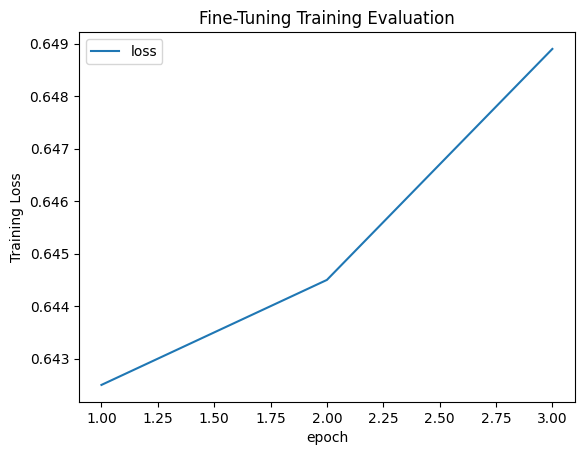

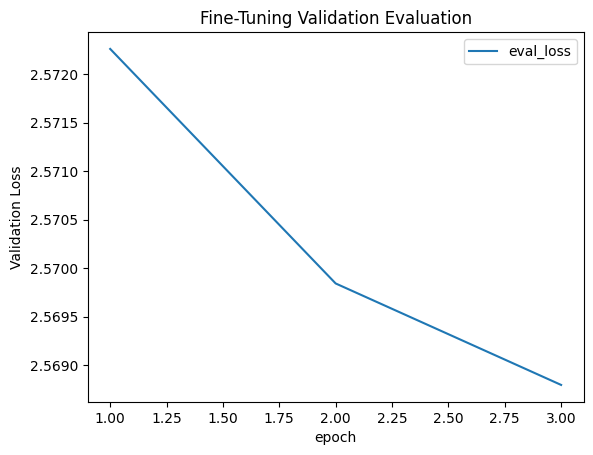

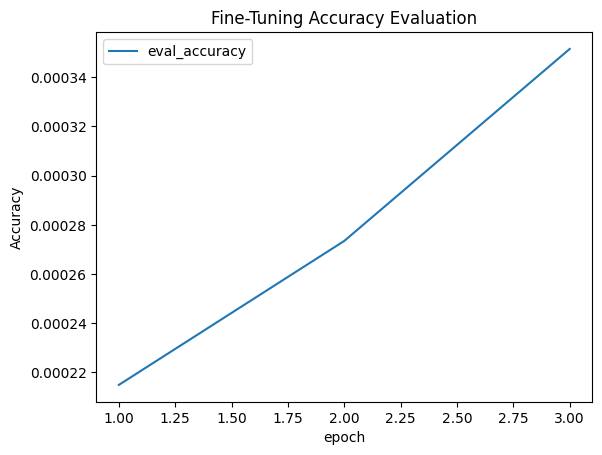

In [204]:
output=get_training_output(l_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [152]:
l2_trainer = make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps",
                                    logging_steps=6))

In [153]:
l2_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
6,0.644600,2.567492,0.000234
12,0.647200,2.566122,0.000176
18,0.642600,2.565707,0.000254
24,0.646200,2.564976,0.000332
30,0.646100,2.564508,0.000293
36,0.644700,2.564010,0.000176
42,0.643200,2.563498,0.000195
48,0.646200,2.563723,0.000195


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch

TrainOutput(global_step=48, training_loss=0.645099272330602, metrics={'train_runtime': 2967.5796, 'train_samples_per_second': 0.505, 'train_steps_per_second': 0.016, 'total_flos': 8976366305280000.0, 'train_loss': 0.645099272330602})

,loss,eval_loss,eval_accuracy
step,,,
6,0.6446,2.567492,0.000234
12,0.6472,2.566122,0.000176
18,0.6426,2.565707,0.000254
24,0.6462,2.564976,0.000332
30,0.6461,2.564508,0.000293
36,0.6447,2.564010,0.000176
42,0.6432,2.563498,0.000195
48,0.6462,2.563723,0.000195


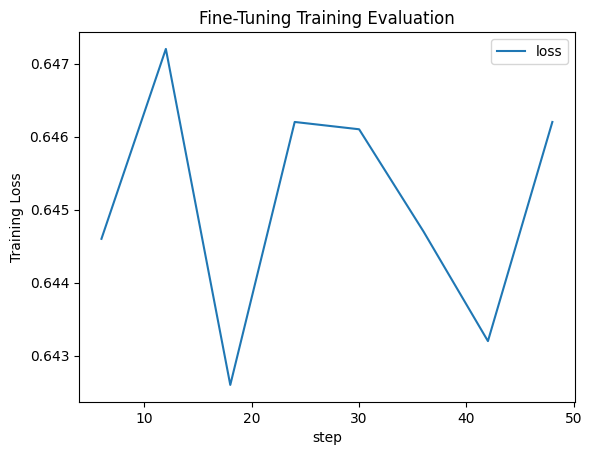

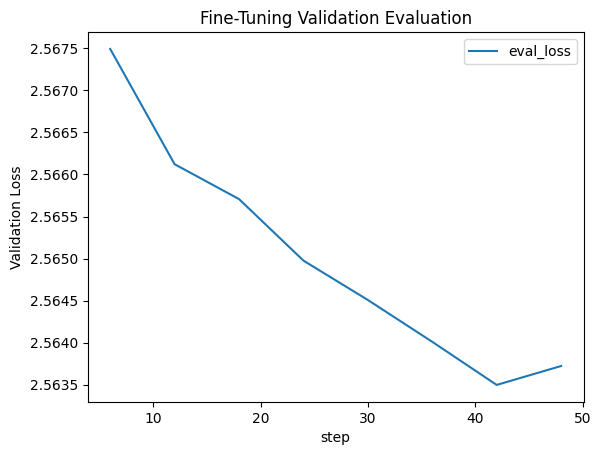

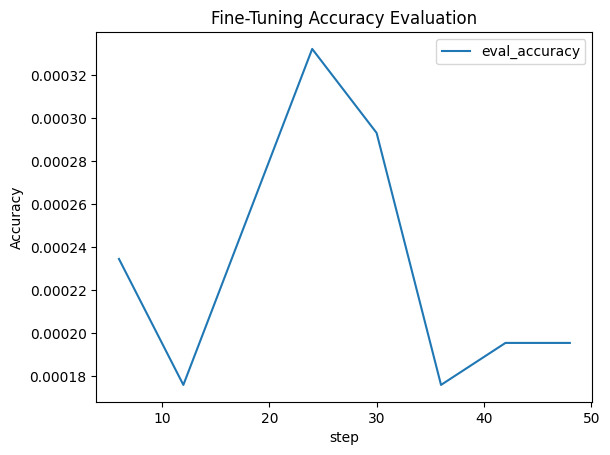

In [155]:
output=get_training_output(l2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [213]:
m_trainer.model.save_pretrained('./fine_tuned_mis/')


In [215]:
m2_trainer.model.save_pretrained('./fine_tuned_mis2/')
l_trainer.model.save_pretrained('./fine_tuned_lla/')
l2_trainer.model.save_pretrained('./fine_tuned_lla2/')

You are using a model of type mistral to instantiate a model of type llama. This is not supported for all configurations of models and can yield errors.
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
You are using a model of type mistral to instantiate a model of type llama. This is not supported for all configurations of models and can yield errors.


In [ ]:
# try a different version of llama3, see how this impacts performance
l2_tokenized_stage1_train=map_data(ds_gst1_train, lla_323, lla_323_tokenizer)
l2_tokenized_stage1_test=map_data(ds_gst1_test, lla_323, lla_323_tokenizer)

In [ ]:
ll2_lora_model=get_peft_model(lla_323, config)
print_trainable_parameters(ll2_lora_model)

In [ ]:
l23_trainer = SFTTrainer(
    model=ll2_lora_model,
    train_dataset=l2_tokenized_stage1_train,
    eval_dataset=l2_tokenized_stage1_test,
    peft_config=config,
    args=training_args,
    compute_metrics=compute_metrics
)
l23_trainer.train()